# Tutorial on how to use Brain_Data() Class
### Written by Luke Chang
<p>Brain_Data() is a python class in the nltools codebase that provides a representation of imaging data that is amenable to easily running statistical models.  It is based on the fmri_data() class in Matlab developed by Tor Wager distributed in the <a href=https://github.com/canlab/CanlabCore>canlabcore repository</a>.  The class relies heavily on <a href = http://nilearn.github.io>nilearn</a>. The basic idea of the class is to represent 3D or 4D data in vector form so that statistical operations can be run more efficiently.  3D data becomes 1D and 4D data becomes 2D.
</p>


## Initialize Python Modules
<p>Make sure you change the path of the output_dir to where you would like to run this tutorial.</p>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import numpy as np
import pandas as pd
import os
import sys
import time
from nltools.analysis import Predict, Roc
from nltools.stats import threshold
from nltools.data import Brain_Data
from nltools.simulator import Simulator
from nilearn.plotting.img_plotting import plot_epi, plot_roi
import matplotlib.pyplot as plt

from copy import deepcopy

output_dir = '/Users/lukechang/Downloads/Test_Brain_Data'

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Create some fake data
<p>For this tutorial we will first create some fake data using nltools simulator() class.</p>

In [2]:
tic = time.time() #Start Timer

sim = Simulator()
r = 10
sigma = .5
cor = .8
cov = .6
reps = 10
n_sub = 10
sim.create_cov_data(cor, cov, sigma, radius=r, reps = reps, n_sub = n_sub, output_dir = output_dir)
print 'Simulation: Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer


/usr/local/lib/python2.7/site-packages/nilearn/signal.py:50: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/usr/local/lib/python2.7/site-packages/nltools-0.2-py2.7.egg/nltools/simulator.py:257: RuntimeWarning: covariance is not positive-semidefinite.
  mv_sim = np.random.multivariate_normal(np.zeros([n_vox+1]),cov_matrix, size=reps)


Simulation: Elapsed: 34.36 seconds


## Load Data Brain_Data Class
<p>next we will load data the data we created as a Brain_Data() instance.  This requires specifying a nibabel instance, or a valid file name pointing to nifiti data.  You can optionally specify a list of files.  To run a prediction analysis you must specify training labels as 'Y'.  Here we will load the simulated Y data.</p>

In [2]:
tic = time.time() #Start Timer

y=pd.read_csv(os.path.join(output_dir,'y.csv'),header=None,index_col=None)
y=np.array(y)[0]
dat = Brain_Data(data=os.path.join(output_dir,'centered_sphere_cor0.8_cov0.8_sigma1.nii.gz'),Y=y)

print 'Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

Elapsed: 9.55 seconds


## Common Brain_Data() Methods
<p>There are many methods for the Brain_Data() class that can help with basic manipulation of the data.  Many methods can be chained as they can output a Brain_Data() instance.</p>

Shape of dat:  (100, 238955)
Shape of mean of dat:  (238955,)
Shape of standard Deviation of dat:  (238955,)
Plot Standard Deviation of dat: 
Plot 5th image in dat: 


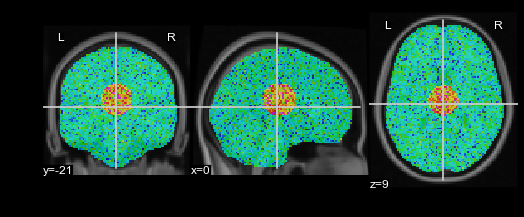

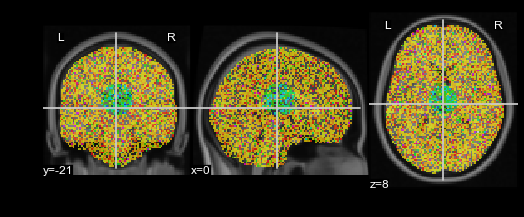

In [3]:
# Find the dimensions of the data.  images x voxels
print 'Shape of dat: ', dat.shape()

# Create a mean for every voxel over images
dat.mean()

# Show the dimensions of the mean image
print 'Shape of mean of dat: ', dat.mean().shape()

# Calculate the Standard deviation for each voxel across images
print 'Shape of standard Deviation of dat: ', dat.std().shape()

# We can create quick plots to inspect the data.
print 'Plot Standard Deviation of dat: '
dat.std().plot()

# We can convert the Brain_Data() instance into a nibabel instance.
d = dat.to_nifti
d()

# Brain_Data() instances can be sliced to select specific images
print 'Plot 5th image in dat: '
dat[5].plot()

## Statistical Analyses
<p>There are several methods to conduct statistical analyses such as:
<ul>
<li>One sample t-tests</li>
<li>Univariate regression</li>
<li>Multivariate prediction</li>
</ul>
</p>
<p>The results of the statistical analyses are output as dictionaries, which can be indexed to find Brain_Data() instances containing each result (e.g., t, p images).  The results can be thresholded usin the threshold() methods.</p>

Plot the results of a one sample t-test
Threshold the results using FDR with q<.05 and plot
Plot the beta parameters estimated using OLS for a univariate regression
Threshold the results using FDR with q<.05 and plot


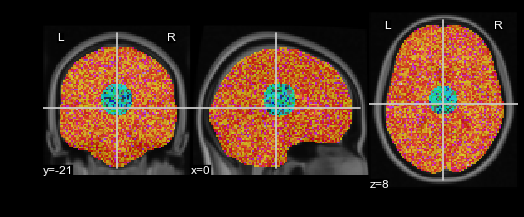

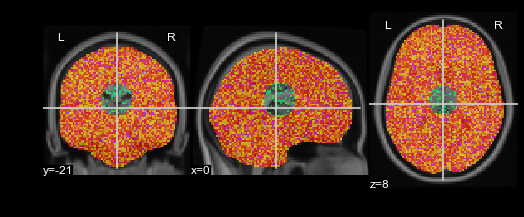

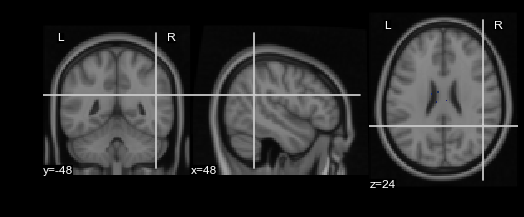

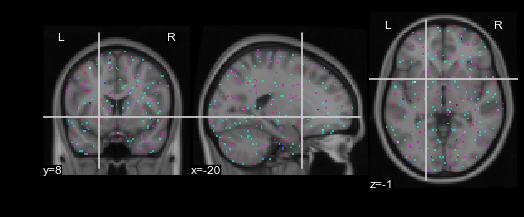

In [4]:
# Run a one-sample T-test
out = dat.ttest()
print 'Plot the results of a one sample t-test'
out['t'].plot()

# Threshold t-test results with FDR
print 'Threshold the results using FDR with q<.05 and plot'
tt = threshold(out['t'], out['p'], threshold_dict={'fdr':.05})
tt.plot()

# Run a univariate regression for a design matrix containing an intercept and one independent variable
# for one Subject.  
# X matrix must be a pandas instance
dat.X = pd.DataFrame({'Intercept':np.ones(len(dat.Y)),'X1':dat.Y},index=None)
out = dat.regress()
print 'Plot the beta parameters estimated using OLS for a univariate regression'
out['beta'][1].plot()

# Threshold t-test results with FDR
print 'Threshold the results using FDR with q<.05 and plot'
i=1
tt = threshold(out['t'][i], out['p'][i], threshold_dict={'fdr':.05})
tt.plot()


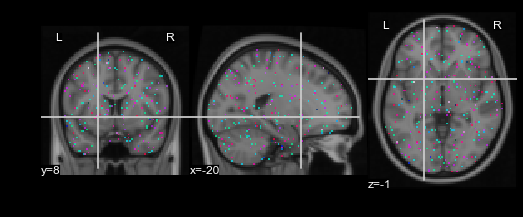

In [33]:
dat.X = pd.DataFrame({'Intercept':np.ones(len(dat.Y)),'X1':dat.Y},index=None)
dat.X
out = dat.regress()
# print 'Plot the beta parameters estimated using OLS for a univariate regression'
# out['t'][1].plot()
# out['t'].shape()
tt = threshold(out['t'][1], out['p'][1], threshold_dict={'fdr':.05})
tt.plot()

## Run a 2-stage multilevel regression akin to SPM
<p>Here we are going to run a separate regression for each subject and concatenate beta files and then run a one-sample t-test across subjects.</p>

In [7]:
n_trials = 10
n_subs = 10

start = 0
stop = n_trials
# all = dat.empty()
dat.X = pd.DataFrame({'Intercept':np.ones(len(dat.Y)),'X1':dat.Y},index=None)
for i in xrange(n_subs):
    sub = deepcopy(dat)
    sub.data = dat.data[start:stop]
    sub.X = dat.X.ix[start:stop-1,:]
    sub_out = sub.regress()
    start = start + n_trials
    stop = stop + n_trials
    all.append(sub_out['beta'][1])

AttributeError: 'builtin_function_or_method' object has no attribute 'append'

In [9]:
# if all.isempty():
#     all.data=sub_out['beta'][1]
l2 = all.ttest()
l2['t'].plot()
thr = threshold(l2['t'],l2['p'],threshold_dict={'fdr':.05})

AttributeError: 'builtin_function_or_method' object has no attribute 'ttest'

(array([  4.,   4.,   8.,   7.,  14.,  19.,  21.,   7.,  11.,   5.]),
 array([-0.24228297, -0.19826498, -0.15424698, -0.11022899, -0.066211  ,
        -0.02219301,  0.02182498,  0.06584297,  0.10986096,  0.15387895,
         0.19789694]),
 <a list of 10 Patch objects>)

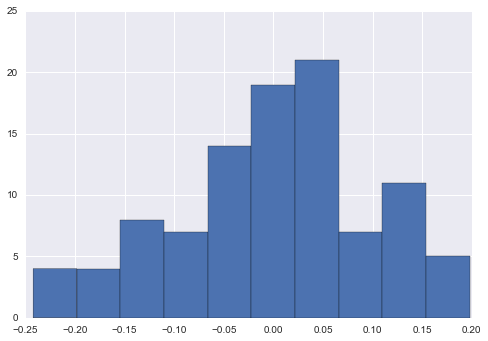

In [6]:
from nltools.stats import test_model

data = deepcopy(dat)
weight_map = deepcopy(out['t'][1])
pexp = test_model(data=data,weight_map=weight_map, method='correlation')
plt.hist(pexp)

In [21]:
from nltools.utils import get_resource_path, set_algorithm

self = deepcopy(dat)
algorithm='ridge'

from nltools.analysis import Predict
if algorithm is not None:
    self_alg = set_algorithm(algorithm)

# if self.algorithm is None:
#     raise ValueError("Make sure you specify an 'algorithm' to use.")

# # Overall Fit for weight map
# predictor = self.predictor
# predictor.fit(self.data, self.Y)
# self.yfit_all = predictor.predict(self.data)
# if self.prediction_type == 'classification':
#     if self.algorithm not in ['svm','ridgeClassifier','ridgeClassifierCV']:
#         self.prob_all = predictor.predict_proba(self.data)
#     else:
#         dist_from_hyperplane_all = predictor.decision_function(self.data)
#         if self.algorithm == 'svm' and self.predictor.probability:
#             self.prob_all = predictor.predict_proba(self.data)

# # Cross-Validation Fit
# if cv_dict is not None:
#     self.set_cv(cv_dict)

# dist_from_hyperplane_xval = None

# if hasattr(self, 'cv'):
#     predicter_cv = self.predictor
#     self.yfit_xval = self.yfit_all.copy()
#     if self.prediction_type == 'classification':
#         if self.algorithm not in ['svm','ridgeClassifier','ridgeClassifierCV']:
#             self.prob_xval = np.zeros(len(self.Y))
#         else:
#             dist_from_hyperplane_xval = np.zeros(len(self.Y))
#             if self.algorithm == 'svm' and self.predictor.probability:
#                 self.prob_xval = np.zeros(len(self.Y))

#     for train, test in self.cv:
#         predicter_cv.fit(self.data[train], self.Y[train])
#         self.yfit_xval[test] = predicter_cv.predict(self.data[test])
#         if self.prediction_type == 'classification':
#             if self.algorithm not in ['svm','ridgeClassifier','ridgeClassifierCV']:
#                 self.prob_xval[test] = predicter_cv.predict_proba(self.data[test])
#             else:
#                 dist_from_hyperplane_xval[test] = predicter_cv.decision_function(self.data[test])
#                 if self.algorithm == 'svm' and self.predictor.probability:
#                     self.prob_xval[test] = predicter_cv.predict_proba(self.data[test])

# # Save Outputs
# if save_images:
#     self._save_image(predictor)

# if save_output:
#     self._save_stats_output(dist_from_hyperplane_xval)

# if save_plot:
#     if hasattr(self, 'cv'):
#         self._save_plot(predicter_cv)
#     else:
#         self._save_plot(predictor)

# # Print Results
# if self.prediction_type == 'classification':
#     self.mcr_all = np.mean(self.yfit_all==self.Y)
#     print 'overall accuracy: %.2f' % self.mcr_all
#     if hasattr(self,'cv'):
#         self.mcr_xval = np.mean(self.yfit_xval==self.Y)
#         print 'overall CV accuracy: %.2f' % self.mcr_xval
# elif self.prediction_type == 'prediction':
#     self.rmse_all = np.sqrt(np.mean((self.yfit_all-self.Y)**2))
#     self.r_all = np.corrcoef(self.Y,self.yfit_all)[0,1]
#     print 'overall Root Mean Squared Error: %.2f' % self.rmse_all
#     print 'overall Correlation: %.2f' % self.r_all
#     if hasattr(self,'cv'):
#         self.rmse_xval = np.sqrt(np.mean((self.yfit_xval-self.Y)**2))
#         self.r_xval = np.corrcoef(self.Y,self.yfit_xval)[0,1]
#         print 'overall CV Root Mean Squared Error: %.2f' % self.rmse_xval
#         print 'overall CV Correlation: %.2f' % self.r_xval


TypeError: 'type' object does not support item assignment

In [3]:
dat.append(dat)

In [4]:
dat.shape()

(200, 238955)